In [1]:
import json
import numpy as np
import sys
sys.path.append('../src')
import standard_gwtransf as gw
import os
import pycbc
import pycbc.noise
import pycbc.psd
from pycbc.frame import query_and_read_frame
from pycbc.types import timeseries
from pycbc.psd import inverse_spectrum_truncation, interpolate
from pycbc.waveform import get_fd_waveform, get_td_waveform
import pycbc.filter.matchedfilter as mfilter
from pycbc import frame as Fr
import matplotlib.pyplot as plt
import scipy.signal

### Read in details of the LVC-NR catalog, and separate out the waveforms from the SXS catalog

In [2]:
f_lvcnr = open('/home/abhirup/ligo-nr-data/lvcnr-lfs.json', 'r')
datastore = json.load(f_lvcnr)
f_lvcnr.close()

sxs_list = []

for idx in range(len(datastore)):
    if datastore[idx]['NR-group'] == 'SXS':
        sxs_list.append(idx)   

### Read in science quality data stretches from O1 and O2
For O2, we have chosen coincident segments for HL and HLV configurations, separately.

In [3]:
o1_L1H1_start_times, o1_L1H1_end_times, o1_L1H1_stretches = np.loadtxt('../data/systematics_error_characterisation/o1_L1H1_quality_segments.txt', unpack=True)
o2_L1H1_start_times, o2_L1H1_end_times, o2_L1H1_stretches = np.loadtxt('../data/systematics_error_characterisation/o2_L1H1_quality_segments.txt', unpack=True)
o2_L1H1V1_start_times, o2_L1H1V1_end_times, o2_L1H1V1_stretches = np.loadtxt('../data/systematics_error_characterisation/o2_L1H1V1_quality_segments.txt', unpack=True)

### Specifying the parameters of the binary to be simulated using a specific SXS-NR waveform
The SXS waveform has information about the mass ratio, q or (m1, m2) (normalised to a total mass M = 1 M_sun) and the spins: (s1x, s1y, s1z, s2x, s2y, s2z). We choose the other parameters (iota, pol, ra, dec, snr) and normalise to a total mass M = 100 M_sun.

In [4]:
idx = 500#np.random.choice(sxs_list)

name = datastore[idx]['name'].replace(':','_')
path = datastore[idx]['path']

print '... chose:', name, idx

M = 100.

m1, m2 = datastore[idx]['mass1']*M, datastore[idx]['mass2']*M
s1x, s1y, s1z = datastore[idx]['spin1x'], datastore[idx]['spin1y'], datastore[idx]['spin1z']
s2x, s2y, s2z = datastore[idx]['spin2x'], datastore[idx]['spin2y'], datastore[idx]['spin2z']

iota = 0.
pol = 0.
ra = 0.
dec = 0.
snr = 500.

... chose: SXS_BBH_0224 500


### Detector configuration
For this simulation, we also choose a HL configutation and a 128 second data stretch [1174018914, 1174019042] and place the trigger at a geocentric time midway in the segment at 1174018978 second.

In [5]:
ifo_map = {'HL':'H1 L1','HLV':'H1 L1 V1'}
det_config, obs_run = 'HL', 'o2'
gps_start_time, gps_end_time, geocentric_end_time = 1174018914, 1174019042, 1174018978.0

tag = name + obs_run + det_config

### Creating the injection files using pycbc_generate_hwinj
This outputs an xml.gz file containing the details of the binary, and injection files containing the strain time series in each detector. Also, if explicitly asked, it will also return the PSDs for each detector.

To generate a waveform at a specific SNR, one would need to pass a specific PSD and a psd-start-freq for each detector. This PSD can be analytical or computed from a frame, in which case, one would need to provide frame details, ie, frame type (or data-type, eg L1_CLEANED_HOFT_C02) and channel name (eg, DCH-CLEAN_STRAIN_C02, which is usually the GW strain channel).

In [6]:
os.system("pycbc_generate_hwinj --numrel-data /home/abhirup/ligo-nr-data/lvcnr-lfs/%s --approximant NR_hdf5 --order pseudoFourPN --waveform-low-frequency-cutoff 25 --mass1 %f --mass2 %f --spin1x %f --spin1y %f --spin1z %f --spin2x %f --spin2y %f --spin2z %f --inclination %f --polarization %f --ra %f --dec %f --instruments %s --sample-rate H1:16384 L1:16384 V1:16384 --frame-type H1:H1_CLEANED_HOFT_C02 L1:L1_CLEANED_HOFT_C02 V1:V1O2Repro2A --channel-name H1:DCH-CLEAN_STRAIN_C02 L1:DCH-CLEAN_STRAIN_C02 V1:Hrec_hoft_V1O2Repro2A_16384Hz --taper TAPER_START --network-snr %f --low-frequency-cutoff 25.0 --high-frequency-cutoff 1024.0 --psd-estimation median --psd-segment-length 16 --psd-segment-stride 8 --pad-data 8 --geocentric-end-time %d --gps-start-time %d --gps-end-time %d --strain-high-pass 1 --psd-output H1:%s_%d_H1_psd.txt L1:%s_%d_L1_psd.txt V1:%s_%d_V1_psd.txt --tag %s"%(path, m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, iota, pol, ra, dec, ifo_map[det_config], snr, geocentric_end_time, gps_start_time, gps_end_time, tag, geocentric_end_time-6, tag, geocentric_end_time-6, tag, geocentric_end_time-6, tag))

0

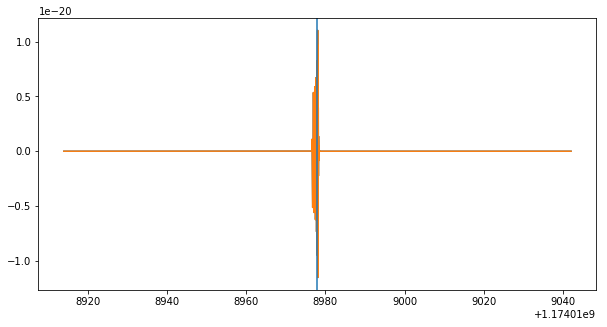

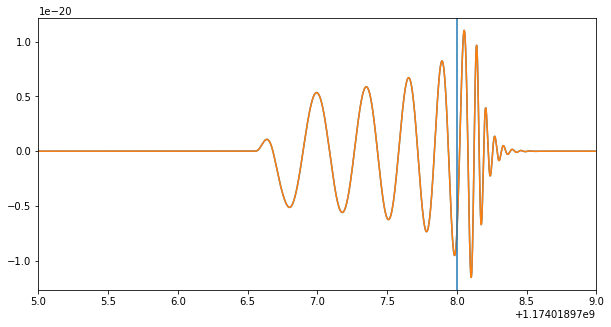

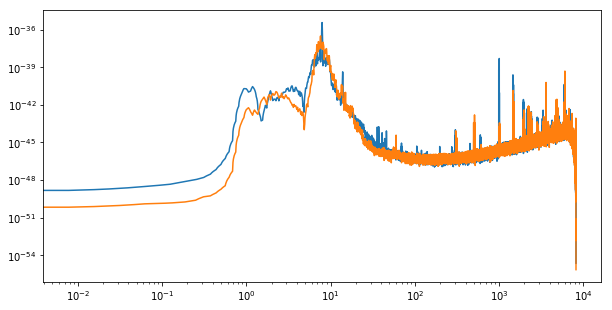

In [7]:
SXS_BBH_0224o2HL_1174018972_H1_inj = np.loadtxt('./SXS_BBH_0224o2HL_1174018972_H1.txt')
SXS_BBH_0224o2HL_1174018972_L1_inj = np.loadtxt('./SXS_BBH_0224o2HL_1174018972_L1.txt')

time_array = np.linspace(gps_start_time, gps_end_time, len(SXS_BBH_0224o2HL_1174018972_H1_inj))

freq_H1, SXS_BBH_0224o2HL_1174018972_H1_psd = np.loadtxt('SXS_BBH_0224o2HL_1174018972_H1_psd.txt', unpack=True)
freq_L1, SXS_BBH_0224o2HL_1174018972_L1_psd = np.loadtxt('SXS_BBH_0224o2HL_1174018972_L1_psd.txt', unpack=True)

plt.figure(figsize=(10,5))
plt.plot(time_array, SXS_BBH_0224o2HL_1174018972_H1_inj)
plt.plot(time_array, SXS_BBH_0224o2HL_1174018972_H1_inj)
plt.axvline(x=geocentric_end_time)

plt.figure(figsize=(10,5))
plt.plot(time_array, SXS_BBH_0224o2HL_1174018972_H1_inj)
plt.plot(time_array, SXS_BBH_0224o2HL_1174018972_H1_inj)
plt.axvline(x=geocentric_end_time)
plt.xlim([geocentric_end_time-3, geocentric_end_time+1])

plt.figure(figsize=(10,5))
plt.loglog(freq_H1, SXS_BBH_0224o2HL_1174018972_H1_psd)
plt.loglog(freq_L1, SXS_BBH_0224o2HL_1174018972_L1_psd)

plt.show()

### Inserting the injection 
pycbc_insert_frame_hwinj creates a .gwf frame file with a specific channel $ifo:HWINJ_INJECTED, which has the injection created above inserted in noise read from a specific channel (eg, DCH-CLEAN_STRAIN_C02) of a specific frame/data-type (eg, H1_CLEANED_HOFT_C02)

In [8]:
os.system('pycbc_insert_frame_hwinj --frame-type H1_CLEANED_HOFT_C02 --channel-name H1:DCH-CLEAN_STRAIN_C02 --gps-start-time %d --gps-end-time %d --pad-data 8 --sample-rate 16384 --hwinj-file %s_%d_H1.txt  --hwinj-start-time %d --ifo H1 --output-file %s_%d_H-H1HWINJ.gwf --strain-high-pass 1'%(gps_start_time,gps_end_time, tag, geocentric_end_time-6, geocentric_end_time-6, tag, geocentric_end_time-6))
os.system('pycbc_insert_frame_hwinj --frame-type L1_CLEANED_HOFT_C02 --channel-name L1:DCH-CLEAN_STRAIN_C02 --gps-start-time %d --gps-end-time %d --pad-data 8 --sample-rate 16384 --hwinj-file %s_%d_L1.txt  --hwinj-start-time %d --ifo L1 --output-file %s_%d_L-L1HWINJ.gwf --strain-high-pass 1'%(gps_start_time,gps_end_time, tag, geocentric_end_time-6, geocentric_end_time-6, tag, geocentric_end_time-6))

0

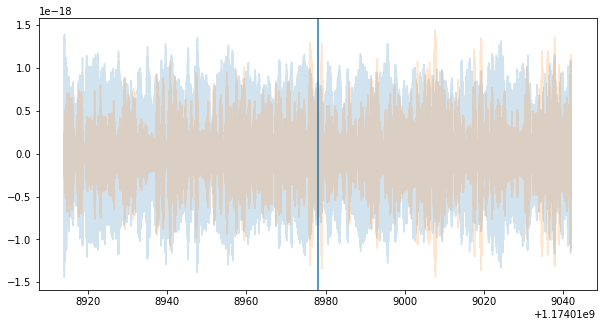

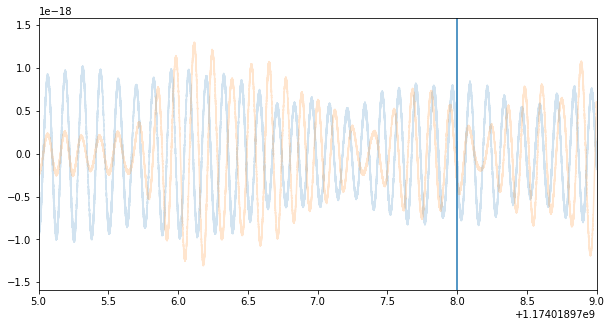

In [13]:
h1_hoft_hwinj = Fr.read_frame('./SXS_BBH_0224o2HL_1174018972_H-H1HWINJ.gwf', 'H1:HWINJ_INJECTED', gps_start_time, gps_end_time)
l1_hoft_hwinj = Fr.read_frame('./SXS_BBH_0224o2HL_1174018972_L-L1HWINJ.gwf', 'L1:HWINJ_INJECTED', gps_start_time, gps_end_time)

plt.figure(figsize=(10,5))
plt.plot(h1_hoft_hwinj.sample_times, h1_hoft_hwinj, alpha=0.2)
plt.plot(l1_hoft_hwinj.sample_times, l1_hoft_hwinj, alpha=0.2)
plt.axvline(x=geocentric_end_time)

plt.figure(figsize=(10,5))
plt.plot(h1_hoft_hwinj.sample_times, h1_hoft_hwinj, alpha=0.2)
plt.plot(l1_hoft_hwinj.sample_times, l1_hoft_hwinj, alpha=0.2)
plt.axvline(x=geocentric_end_time)
plt.xlim([geocentric_end_time-3, geocentric_end_time+1])

plt.show()

### Sanity check: windowing, whitening and bandpassing the injection we just created, to see if we can see the signal from the noise

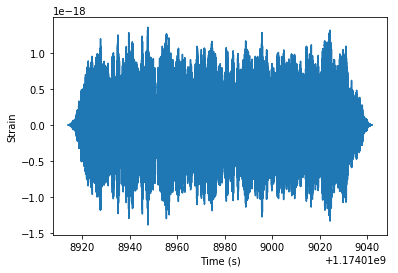

In [10]:
alpha = 0.2 # Parameter of tukey window
tukey_window = scipy.signal.tukey(len(h1_hoft_hwinj),alpha)
h1_hoft_hwinj_windowed = h1_hoft_hwinj * tukey_window
t0 = geocentric_end_time

# plotting windowed data
plt.plot(h1_hoft_hwinj_windowed.sample_times, h1_hoft_hwinj_windowed)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

In [11]:
def data_whiten(self, segment_duration, max_filter_duration, trunc_method='hann',
                     remove_corrupted=True, low_frequency_cutoff=None,
                     return_psd=False, **kwds):
        """ Return a whitened time series

        Parameters
        ----------
        segment_duration: float
            Duration in seconds to use for each sample of the spectrum.
        max_filter_duration : int
            Maximum length of the time-domain filter in seconds.
        trunc_method : {None, 'hann'}
            Function used for truncating the time-domain filter.
            None produces a hard truncation at `max_filter_len`.
        remove_corrupted : {True, boolean}
            If True, the region of the time series corrupted by the whitening
            is excised before returning. If false, the corrupted regions
            are not excised and the full time series is returned.
        low_frequency_cutoff : {None, float}
            Low frequency cutoff to pass to the inverse spectrum truncation.
            This should be matched to a known low frequency cutoff of the
            data if there is one.
        return_psd : {False, Boolean}
            Return the estimated and conditioned PSD that was used to whiten
            the data.
        kwds : keywords
            Additional keyword arguments are passed on to the `pycbc.psd.welch` method.

        Returns
        -------
        whitened_data : TimeSeries
            The whitened time series
        """
        from pycbc.psd import inverse_spectrum_truncation, interpolate
        # Estimate the noise spectrum
        psd = self.psd(segment_duration, **kwds)
        psd = interpolate(psd, self.delta_f)
        max_filter_len = int(max_filter_duration * self.sample_rate)

        # Interpolate and smooth to the desired corruption length
        psd = inverse_spectrum_truncation(psd,
                   max_filter_len=max_filter_len,
                   low_frequency_cutoff=low_frequency_cutoff,
                   trunc_method=trunc_method)

        # Whiten the data by the asd
        norm = 1./np.sqrt(1./(self.delta_t*2))
        
        white = ((self.to_frequencyseries() / psd**0.5) * norm).to_timeseries()
        
        if remove_corrupted:
            white = white[int(max_filter_len/2):int(len(self)-max_filter_len/2)]

        if return_psd:
            return white, psd

        return white

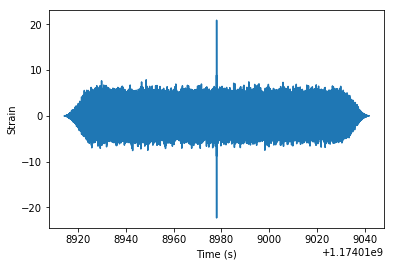

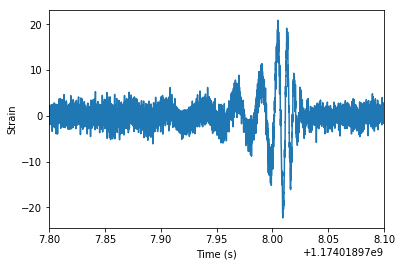

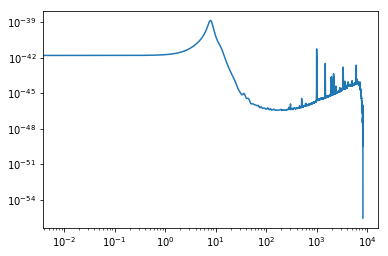

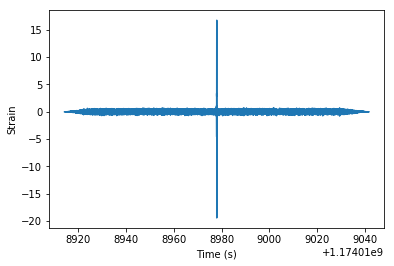

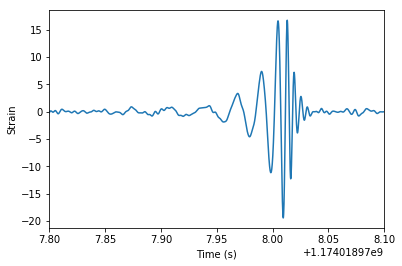

In [14]:
# whitening data
h1_hoft_hwinj_whitened, psd = data_whiten(h1_hoft_hwinj_windowed,segment_duration=2, max_filter_duration=0.5, trunc_method='hann',
                     remove_corrupted=True,return_psd=True)

# plotting whitened data
plt.plot(h1_hoft_hwinj_whitened.sample_times, h1_hoft_hwinj_whitened)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

# plotting whitened data around the trigger time for GW150914
plt.plot(h1_hoft_hwinj_whitened.sample_times, h1_hoft_hwinj_whitened)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.xlim(t0 - 0.2, t0 + .1)
plt.show()

# plotting the PSD used to whiten the data
plt.loglog(psd.sample_frequencies, psd)
plt.show()

# bandpassing the whitened data between 30 and 250 Hz
h1_hoft_hwinj_whitened_bndpassd = h1_hoft_hwinj_whitened.highpass_fir(30, 512).lowpass_fir(250, 512)

# plotting bandpassed whitened data
plt.plot(h1_hoft_hwinj_whitened_bndpassd.sample_times, h1_hoft_hwinj_whitened_bndpassd)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

# plotting bandpassed whitened data around the trigger time for GW150914
plt.plot(h1_hoft_hwinj_whitened_bndpassd.sample_times, h1_hoft_hwinj_whitened_bndpassd)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.xlim(t0 - 0.2, t0 + .1)
plt.show()